In [1]:
!pip install keplergl
!pip3 install pickle5
!pip install pygeohash
!pip install lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 6.3 MB/s eta 0:00:0000:0100:010m
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for keplergl: filename=keplergl-0.3.2-py2.py3-none-any.whl size=17922320 sha256=0d497fe0bbbff2a2f1d1805109536c8657e0dcab8287ac654359335173018a64
  Stored in directory: /root/.cache/pip/wheels/4b/19/e5/0852b7888ee350e9c57087ccc61eeab9daf50f5caac9c690ec
Successfully built keplergl
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.4/256.4 kB 470.5 kB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for pygeohash: filename=pygeohash-1.2.0-py2.py3-none-any.whl size=6167 sha256=eb7780ea897ecf60ad3855a3393486eb2f21cc69f3a55dc86d472571a1834bba
  Stored in directory: /root/.cache/pip/wheels/e2/ed/86/be7141d743cfb4aebac76406187154cd78fe9e6535d872187a
Successfully built pygeohash


In [2]:
!pip install h3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 1.3 MB/s eta 0:00:00a 0:00:010m


In [3]:
!cp -r /kaggle/input/cian-parser-v1/cianparser-main/* 
!pip install -e /kaggle/input/cian-parser-v1/cianparser-main

cp: target '/kaggle/input/cian-parser-v1/cianparser-main/setup.py' is not a directory
Obtaining file:///kaggle/input/cian-parser-v1/cianparser-main
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 179.9 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 753.8 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 6.3 MB/s eta 0:00:0000:0100:010m
  Running setup.py develop for cianparser
    error: subprocess-exited-with-error
    
    × python setup.py develop did not run successfully.
    │ exit code: 1
    ╰─> [8 lines of output]
        running develop
        running egg_info
        creating cianparser.egg-info
        /opt/conda/lib/python3.7/site-packages/setuptools/command/easy_install.py:159: EasyInstallDeprecationWarning: easy_install command is deprecated. Use build and pip and other standards-based tools.
          EasyInstallDeprecationWarning,
        /opt/conda/

In [4]:
!jupyter nbextension install --py --sys-prefix keplergl # can be skipped for notebook 5.3 and above
!jupyter nbextension enable --py --sys-prefix keplergl # can be skipped for notebook 5.3 and above

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string
Installing /opt/conda/lib/python3.7/site-packages/keplergl/static -> keplergl-jupyter
Up to date: /opt/conda/share/jupyter/nbextensions/keplergl-jupyter/keplergl.html
Up to date: /opt/conda/share/jupyter/nbextensions/keplergl-jupyter/main.js
Up to date: /opt/conda/share/jupyter/nbextensions/keplergl-jupyter/extension.js
Up to date: /opt/conda/share/jupyter/nbextensions/keplergl-jupyter/index.js
Up to date: /opt/conda/share/jupyter/nbextensions/keplergl-jupyter/extension.js.map
Up to date: /opt/conda/share/jupyter/nbextensions/keplergl-jupyter/index.js.map
- Validating: OK

    To initialize this nbextension in the browser every time the notebook (or other app) loads:
    
          jupyter nbext

In [146]:
import sys
import pandas as pd
import os
from keplergl import KeplerGl
import numpy as np

import pickle5 as pickle
from h3 import h3
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree
import math
from sklearn.model_selection import KFold

from  sklearn.metrics import mean_absolute_error

import pygeohash as pgh
import seaborn as sns

def load_pickle(file_path):
    with open(file_path, 'rb') as handle:
        return pickle.load(handle)
        
def save_pickle(obj, filepath): 
    with open(filepath, 'wb') as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)
pd.set_option('display.max_columns', None)

Для корректной работы KeplerGl в jupyter notebook: https://docs.kepler.gl/docs/keplergl-jupyter

In [6]:
os.makedirs('configs', exist_ok=True)

In [7]:
ROOT = '/kaggle/input/geo-branch-data/train/train'
geo_id = 'geo_h3_10'
df_roads = pd.read_csv(f"{ROOT}/roads_dataset.csv")
df_transport = pd.read_csv(f"{ROOT}/routes_dataset.csv")
df_population = pd.read_csv(f"{ROOT}/rosstat_population_all_cities.csv")
df_isochrones = pd.read_csv(f"{ROOT}/isochrones_walk_dataset.csv")
df_stops = pd.read_csv(f"{ROOT}/osm_stops.csv")
df_companies = pd.read_csv(f"{ROOT}/osm_amenity.csv")

In [8]:
df_population[df_population.city == 'Санкт-Петербург']['geo_h3_10'].drop_duplicates().count()

11570

## Дороги
**highway** - тип дороги

**geometry** - shapely геометрия дороги

**oneway** - признак одностороннего движения

**name** - название улицы

**city** - город

In [9]:
df_roads.head(20)

,osmid,highway,geometry,oneway,name,city
0,33997807,primary_link,"LINESTRING (30.3314215 59.895094, 30.3311238 5...",False,NaN,Санкт-Петербург
1,201380605,primary,"LINESTRING (30.3314215 59.895094, 30.3318177 5...",True,Лиговский проспект,Санкт-Петербург
2,33997784,primary_link,"LINESTRING (30.3375246 59.8992885, 30.3379026 ...",False,NaN,Санкт-Петербург
3,178581714,primary,"LINESTRING (30.3375246 59.8992885, 30.3372282 ...",True,Лиговский проспект,Санкт-Петербург
4,4459876,primary,"LINESTRING (30.3395524 59.9017314, 30.3398299 ...",True,Воздухоплавательная улица,Санкт-Петербург
5,387048069,primary,"LINESTRING (30.3395524 59.9017314, 30.3391877 ...",True,Лиговский проспект,Санкт-Петербург
6,199744986,residential,"LINESTRING (30.3468797 59.9098089, 30.346696 5...",True,Прилукская улица,Санкт-Петербург
7,326724985,primary,"LINESTRING (30.3468797 59.9098089, 30.3468044 ...",True,Лиговский проспект,Санкт-Петербург
8,172592203,residential,"LINESTRING (30.3483705 59.9120443, 30.3481681 ...",True,Курская улица,Санкт-Петербург
9,215377456,tertiary,"LINESTRING (30.3483705 59.9120443, 30.3485495 ...",False,Курская улица,Санкт-Петербург


## Маршруты
**geometry** - shapely геометрия маршрута

**type** - тип общественного транспорта

**city** - город

**name** - идентификатор маршрута

In [10]:
df_transport.head(20)

,geometry,type,city,name
0,"LINESTRING (30.367515 60.012027, 30.367518 60....",tram,Санкт-Петербург,d645920e395fedad7bbbed0eca3fe2e0
1,"LINESTRING (30.231228 60.023206, 30.233159 60....",tram,Санкт-Петербург,b53b3a3d6ab90ce0268229151c9bde11
2,"LINESTRING (30.355657 59.956911, 30.355829 59....",tram,Санкт-Петербург,eccbc87e4b5ce2fe28308fd9f2a7baf3
3,"LINESTRING (30.235013 59.956634, 30.234953 59....",tram,Санкт-Петербург,1679091c5a880faf6fb5e6087eb1b2dc
4,"LINESTRING (30.355545 59.956849, 30.355398 59....",tram,Санкт-Петербург,37693cfc748049e45d87b8c7d8b9aacd
5,"LINESTRING (30.355657 59.956911, 30.355829 59....",tram,Санкт-Петербург,98f13708210194c475687be6106a3b84
6,"LINESTRING (30.348369 59.970938, 30.348552 59....",tram,Санкт-Петербург,7f39f8317fbdb1988ef4c628eba02591
7,"LINESTRING (30.494512 59.908755, 30.494599 59....",tram,Санкт-Петербург,02e74f10e0327ad868d138f2b4fdd6f0
8,"LINESTRING (30.343705 60.059194, 30.343923 60....",tram,Санкт-Петербург,f899139df5e1059396431415e770c6dd
9,"LINESTRING (30.496101 59.917467, 30.495893 59....",tram,Санкт-Петербург,d3d9446802a44259755d38e6d163e820


## Население
**geo_h3_10** - https://eng.uber.com/h3/ : хексагона - полигон в виде соты

**city** - город

**population** - насление в хексагоне

**lat, lon** - широта/долгота центра хексагоны

In [11]:
df_population.head(20)

,geo_h3_10,city,population,lat,lon
0,8a0bb0200907fff,Новосибирск,12,54.942110,83.146356
1,8a0bb0200927fff,Новосибирск,8,54.942144,83.144157
2,8a0bb020092ffff,Новосибирск,28,54.943220,83.145270
3,8a0bb0200937fff,Новосибирск,12,54.941034,83.145243
4,8a0bb0200977fff,Новосибирск,10,54.944296,83.146384
5,8a0bb0204027fff,Новосибирск,290,54.935864,83.126481
6,8a0bb020402ffff,Новосибирск,180,54.936940,83.127594
7,8a0bb0204067fff,Новосибирск,332,54.939126,83.127621
8,8a0bb020406ffff,Новосибирск,225,54.940202,83.128735
9,8a0bb0204117fff,Новосибирск,1164,54.933712,83.124256


## Изохроны 

https://medium.com/@urbica/%D0%B3%D0%B0%D0%BB%D1%8C%D1%82%D0%BE%D0%BD-c7360acf1ec4

**geo_h3_10** - https://eng.uber.com/h3/ : хексагона - полигон в виде соты

**city** - город

**walk_15min** - shapely геометрия 15 минутной пешей доступности из точки (lat, lon)

**lat, lon** - широта/долгота центра хексагоны

In [12]:
df_isochrones.head(20)

,city,walk_15min,geo_h3_10,lat,lon
0,Нижний Новгород,"POLYGON ((43.776762 56.391904, 43.775762 56.39...",8a101601044ffff,56.383627,43.777762
1,Нижний Новгород,"POLYGON ((43.773717 56.39169, 43.772717 56.390...",8a101601045ffff,56.382411,43.777717
2,Нижний Новгород,"POLYGON ((43.773458 56.388816, 43.770682 56.38...",8a10160104cffff,56.380606,43.779458
3,Нижний Новгород,"POLYGON ((43.788412 56.382862, 43.784155 56.38...",8a10160104dffff,56.379391,43.779412
4,Нижний Новгород,"POLYGON ((43.775051 56.391224, 43.773051 56.39...",8a1016010607fff,56.384913,43.785051
5,Нижний Новгород,"POLYGON ((43.785885 56.387469, 43.784024 56.38...",8a101601060ffff,56.385539,43.786885
6,Нижний Новгород,"POLYGON ((43.775005 56.390705, 43.774005 56.39...",8a1016010617fff,56.383698,43.785005
7,Нижний Новгород,"POLYGON ((43.773839 56.390686, 43.772839 56.38...",8a101601061ffff,56.384323,43.786839
8,Нижний Новгород,"POLYGON ((43.772263 56.392765, 43.77162 56.392...",8a1016010627fff,56.385503,43.783263
9,Нижний Новгород,"POLYGON ((43.786097 56.387065, 43.784222 56.38...",8a101601062ffff,56.386129,43.785097


### Магазины-кампании и прочее 
**geo_h3_10** - https://eng.uber.com/h3/ : хексагона - полигон в виде соты

**city** - город

**lat, lon** - широта/долгота центра хексагоны

**остальные колонки** - число организаций типа "название колонки" в хексагоне

In [13]:
df_companies.head(20)

,geo_h3_10,city,Автозапчасти для иномарок,Авторемонт и техобслуживание (СТО),Алкогольные напитки,Аптеки,Банки,Быстрое питание,Доставка готовых блюд,Женская одежда,Кафе,Косметика / Парфюмерия,Ногтевые студии,Овощи / Фрукты,Парикмахерские,Платёжные терминалы,Постаматы,Продуктовые магазины,Пункты выдачи интернет-заказов,Рестораны,Страхование,Супермаркеты,Цветы,Шиномонтаж,lat,lon
0,8a0bb0200a5ffff,Новосибирск,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,54.953869,83.163008
1,8a0bb0200b37fff,Новосибирск,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,54.948563,83.153038
2,8a0bb0201cd7fff,Новосибирск,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,54.958064,83.174064
3,8a0bb0201d97fff,Новосибирск,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,54.953799,83.167407
4,8a0bb0204027fff,Новосибирск,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.935864,83.126481
5,8a0bb020402ffff,Новосибирск,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,54.936940,83.127594
6,8a0bb020404ffff,Новосибирск,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.940167,83.130934
7,8a0bb0204067fff,Новосибирск,NaN,NaN,NaN,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,1.0,NaN,NaN,3.0,NaN,NaN,54.939126,83.127621
8,8a0bb0204107fff,Новосибирск,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,54.934823,83.123169
9,8a0bb0204117fff,Новосибирск,NaN,NaN,NaN,2.0,NaN,1.0,2.0,NaN,NaN,NaN,1.0,1.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,6.0,1.0,NaN,54.933712,83.124256


## Остановки
**osm_id** - идентификатор 

**geo_h3_10** - https://eng.uber.com/h3/ : хексагона - полигон в виде соты

**lat, lon** - широта/долгота центра хексагоны

**type** - тип остановки

**city** - город

**name** - название остановки

In [14]:
df_stops.head(20)

,osm_id,name,lat,lon,type,city,geo_h3_10
0,192192625,Ж/Д Вокзал,56.856321,60.605703,tram_stop,Екатеринбург,8a10c228a68ffff
1,192192653,Кондукторская,56.859895,60.627218,tram_stop,Екатеринбург,8a10dc924177fff
2,192192654,Учителей,56.857951,60.630261,tram_stop,Екатеринбург,8a10dc92402ffff
3,192196917,Новгородцевой,56.836949,60.680253,tram_stop,Екатеринбург,8a10dc920697fff
4,192196926,Сиреневый бульвар,56.835040,60.685064,tram_stop,Екатеринбург,8a10dc923d17fff
5,192202795,ЦПКиО,56.818661,60.638836,tram_stop,Екатеринбург,8a10dc935a37fff
6,192202801,Тверитина,56.822745,60.635928,tram_stop,Екатеринбург,8a10dc9264dffff
7,192237601,7 ключей,56.883559,60.498162,tram_stop,Екатеринбург,8a10c2281d57fff
8,192237617,Маневровая,56.873788,60.518298,tram_stop,Екатеринбург,8a10c22814dffff
9,192237631,Теплоходный проезд,56.863386,60.540655,tram_stop,Екатеринбург,8a10c22832cffff


### Визуализируем данные

In [15]:
# map_config_path = "/kaggle/input/geo-branch-data/map-config.pkl"
# if os.path.isfile(map_config_path):
#     config = load_pickle(map_config_path)
# else:
#     config = {}

In [16]:
# map_kepler = KeplerGl(height = 750, config=config)
# map_kepler.add_data(df_roads, 'дороги')
# map_kepler.add_data(df_transport, 'маршруты транспорта')
# map_kepler.add_data(df_population.drop('geo_h3_10', axis = 1), 'Население')
# map_kepler.add_data(df_isochrones.drop('geo_h3_10', axis = 1), 'Пешая доступность')
# map_kepler.add_data(df_stops.drop('geo_h3_10', axis = 1), 'Остановки')
# map_kepler

In [17]:
# save_pickle(map_kepler.config, "configs/map-config.pkl")

In [18]:
# map_kepler.save_to_html(file_name='first_map.html')

In [19]:
df = pd.read_csv('/kaggle/input/russia-real-estate-2021/input_data.csv', sep=';')
df

,date,price,level,levels,rooms,area,kitchen_area,geo_lat,geo_lon,building_type,object_type,postal_code,street_id,id_region,house_id
0,2021-01-01,2451300,15,31,1,30.3,0.0,56.780112,60.699355,0,2,620000.0,NaN,66,1632918.0
1,2021-01-01,1450000,5,5,1,33.0,6.0,44.608154,40.138381,0,0,385000.0,NaN,1,NaN
2,2021-01-01,10700000,4,13,3,85.0,12.0,55.540060,37.725112,3,0,142701.0,242543.0,50,681306.0
3,2021-01-01,3100000,3,5,3,82.0,9.0,44.608154,40.138381,0,0,385000.0,NaN,1,NaN
4,2021-01-01,2500000,2,3,1,30.0,9.0,44.738685,37.713668,3,2,353960.0,439378.0,23,1730985.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11358145,2021-12-31,6099000,4,9,3,65.0,0.0,56.041539,92.753133,0,0,660030.0,581436.0,24,857003.0
11358146,2021-12-31,2490000,1,10,2,56.9,0.0,55.169949,61.519210,0,0,454079.0,274414.0,74,1820769.0
11358147,2021-12-31,850000,2,2,2,37.0,5.0,55.946206,43.088179,0,0,606101.0,190983.0,52,958329.0
11358148,2021-12-31,4360000,5,5,1,36.0,9.0,61.256383,73.435919,0,0,628406.0,581702.0,86,2156710.0


In [20]:
# питер - 78, 47, 78, 98, 178
# москва - 77, 90, 99, 97, 150, 177, 190, 197, 199, 750, 777, 790, 797
# новосибирск - 54, 154
# нижний новгород - 52, 152
# екатеринбург - 96б 66б 196
df['id_region'].value_counts()

77    1032600
72     865423
23     846948
78     765872
50     754267
       ...   
8        2498
6        1195
87        147
79         55
83         48
Name: id_region, Length: 86, dtype: int64

In [21]:
df = pd.read_csv('/kaggle/input/bankmachinesrussia/target_hakaton_spb.csv', sep=';', encoding='Windows-1251')
df

,gorod,geo_h3_10,lat_h3,lon_h3,atm_category,target,atm_cnt
0,Екатеринбург,8a10c2283357fff,56.865861,60.532224,category4,95.333333,1
1,Екатеринбург,8a10c2288087fff,56.885391,60.588203,category3,30652.666667,4
2,Екатеринбург,8a10c228820ffff,56.891648,60.605399,category2,1162.166667,1
3,Екатеринбург,8a10c2288adffff,56.895039,60.598777,category1,2961.333333,1
4,Екатеринбург,8a10c228944ffff,56.896206,60.625911,category1,2963.333333,1
...,...,...,...,...,...,...,...
533,Санкт-Петербург,8a1106ab67a7fff,59.983488,30.227538,category1,2535.833333,1
534,Санкт-Петербург,8a1106ab6807fff,59.990519,30.205250,category1,23519.500000,2
535,Санкт-Петербург,8a1106ab6807fff,59.990519,30.205250,category4,94.500000,1
536,Санкт-Петербург,8a1106ab6ae7fff,59.996443,30.219656,category2,489.500000,1


In [22]:
df[geo_id].drop_duplicates().count()

495

In [82]:
column_mapper = {
    'Автозапчасти для иномарок': 'autoparts',
    'Авторемонт и техобслуживание (СТО)': 'autoremont',
    'Алкогольные напитки': 'alcohols',
    'Аптеки': 'pharmacies',
    'Банки': 'banks',
    'Быстрое питание': 'fastfood',
    'Доставка готовых блюд': 'delivery',
    'Женская одежда': 'female_clothes',
    'Кафе': 'cafe',
    'Косметика / Парфюмерия': 'cosmetics',
    'Ногтевые студии': 'nails',
    'Овощи / Фрукты': 'vegetables',
    'Парикмахерские': 'hairs',
    'Платёжные терминалы': 'pay_terminals',
    'Постаматы': 'mails',
    'Продуктовые магазины': 'products',
    'Пункты выдачи интернет-заказов': 'internet_orders',
    'Рестораны': 'restaurants',
    'Страхование': 'insurance',
    'Супермаркеты': 'supermarkets',
    'Цветы': 'flowers',
    'Шиномонтаж': 'tires'
}
cat_features = [] 
num_features = ['population'] + list(column_mapper.values())
target = 'target'
features = cat_features + num_features

geo_codes = set(df_isochrones.apply(lambda row: pgh.encode(latitude=row['lat'], longitude=row['lon'], precision=5) ,axis=1).tolist())
geo_mapper = {geo_code: i for i, geo_code in enumerate(geo_codes)}

In [83]:
def prepare_df(df):
    _df = df.drop_duplicates(subset=geo_id)
    _df = _df.merge(df_population, on=geo_id, suffixes=(None, '_y'), how='left').drop(['lat', 'lon', 'city'], axis=1)
    _df = _df.merge(df_companies, on=geo_id, suffixes=(None, '_y'), how='left').drop(['city', 'lat', 'lon'], axis=1).fillna(0)

#     _df['geo_hash'] = _df.apply(lambda row: pgh.encode(latitude=row['lat_h3'], longitude=row['lon_h3'], precision=5) ,axis=1) 
#     _df['geo_hash'] = _df['geo_hash'].apply(lambda item: geo_mapper[item]).astype('category')

    # _df['atm_category'] = _df['atm_category'].str.replace('category', '').astype('category')

    _df = _df.rename(columns=column_mapper)
    for feature in num_features:
        _df[feature] = (_df[feature] - _df[feature].mean())/ _df[feature].std()

    for feature in cat_features:
        _df[f'{feature}_ohe'] = _df[feature]
    _df = pd.get_dummies(_df, columns=[f'{col}_ohe' for col in cat_features], prefix=cat_features)

    return _df

def prepare_target(_df):
    _df[target] = _df[target] / _df['atm_cnt']
    _df[target] = (_df[target] - _df[target].mean())/ _df[target].std()

    _df = _df[_df[target] - _df[target].mean() < 3 * _df[target].std()]
    return _df
df = prepare_df(pd.read_csv('/kaggle/input/bankmachinesrussia/target_hakaton_spb.csv', sep=';', encoding='Windows-1251'))
df = prepare_target(df)
target_df = df.copy()
df

,gorod,geo_h3_10,lat_h3,lon_h3,atm_category,target,atm_cnt,population,autoparts,autoremont,alcohols,pharmacies,banks,fastfood,delivery,female_clothes,cafe,cosmetics,nails,vegetables,hairs,pay_terminals,mails,products,internet_orders,restaurants,insurance,supermarkets,flowers,tires
0,Екатеринбург,8a10c2283357fff,56.865861,60.532224,category4,-0.946104,1,-0.561217,-0.191149,-0.153933,-0.348766,0.672666,-0.459879,0.677326,-0.326136,-0.392482,-0.320251,0.479244,-0.341370,-0.310701,-0.513786,3.226799,-0.539875,-0.268518,0.983289,-0.300538,1.364693,3.662680,5.356807,-0.174742
1,Екатеринбург,8a10c2288087fff,56.885391,60.588203,category3,0.318830,4,-0.561217,-0.191149,-0.153933,-0.348766,-0.630542,1.297960,-0.440262,-0.326136,-0.392482,-0.320251,-0.028734,-0.341370,-0.310701,-0.513786,-0.689439,0.257851,-0.268518,-0.435743,-0.300538,4.977117,-0.594917,-0.470928,-0.174742
2,Екатеринбург,8a10c228820ffff,56.891648,60.605399,category2,-0.767787,1,0.926195,-0.191149,4.079215,-0.348766,-0.630542,-0.459879,-0.440262,-0.326136,-0.392482,-0.320251,-0.536713,-0.341370,-0.310701,1.176074,-0.689439,-0.539875,-0.268518,-0.435743,-0.300538,-0.441518,-0.594917,-0.470928,-0.174742
3,Екатеринбург,8a10c2288adffff,56.895039,60.598777,category1,-0.467063,1,1.340304,-0.191149,-0.153933,-0.348766,-0.630542,-0.459879,-0.440262,-0.326136,-0.392482,-0.320251,-0.536713,-0.341370,-0.310701,-0.513786,-0.689439,-0.539875,-0.268518,-0.435743,-0.300538,-0.441518,-0.594917,-0.470928,-0.174742
4,Екатеринбург,8a10c228944ffff,56.896206,60.625911,category1,-0.466728,1,0.343062,-0.191149,-0.153933,-0.348766,-0.630542,-0.459879,-0.440262,-0.326136,-0.392482,-0.320251,-0.536713,-0.341370,-0.310701,-0.513786,-0.129976,1.055576,-0.268518,-0.435743,-0.300538,-0.441518,0.824282,-0.470928,-0.174742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,Санкт-Петербург,8a1106ab618ffff,59.986278,30.217541,category1,0.796952,1,-0.561217,-0.191149,-0.153933,-0.348766,0.672666,1.297960,-0.440262,-0.326136,-0.131589,-0.320251,-0.536713,-0.341370,-0.310701,-0.513786,2.667337,0.257851,-0.268518,-0.435743,-0.300538,-0.441518,0.824282,-0.470928,-0.174742
491,Санкт-Петербург,8a1106ab67a7fff,59.983488,30.227538,category1,-0.538183,1,-0.561217,-0.191149,-0.153933,-0.348766,-0.630542,-0.459879,-0.440262,-0.326136,-0.392482,-0.320251,-0.536713,-0.341370,-0.310701,-0.513786,-0.689439,-0.539875,-0.268518,-0.435743,-0.300538,-0.441518,-0.594917,-0.470928,-0.174742
492,Санкт-Петербург,8a1106ab6807fff,59.990519,30.205250,category1,1.003559,2,-0.561217,-0.191149,-0.153933,-0.348766,-0.630542,0.419040,1.794915,-0.326136,1.259842,-0.320251,1.495201,-0.341370,-0.310701,2.865933,1.548412,-0.539875,-0.268518,-0.435743,3.080514,-0.441518,0.824282,1.471650,-0.174742
493,Санкт-Петербург,8a1106ab6ae7fff,59.996443,30.219656,category2,-0.880220,1,-0.561217,-0.191149,-0.153933,-0.348766,-0.630542,-0.459879,-0.440262,-0.326136,-0.392482,-0.320251,-0.536713,-0.341370,-0.310701,-0.513786,-0.689439,-0.539875,-0.268518,-0.435743,-0.300538,-0.441518,-0.594917,-0.470928,-0.174742


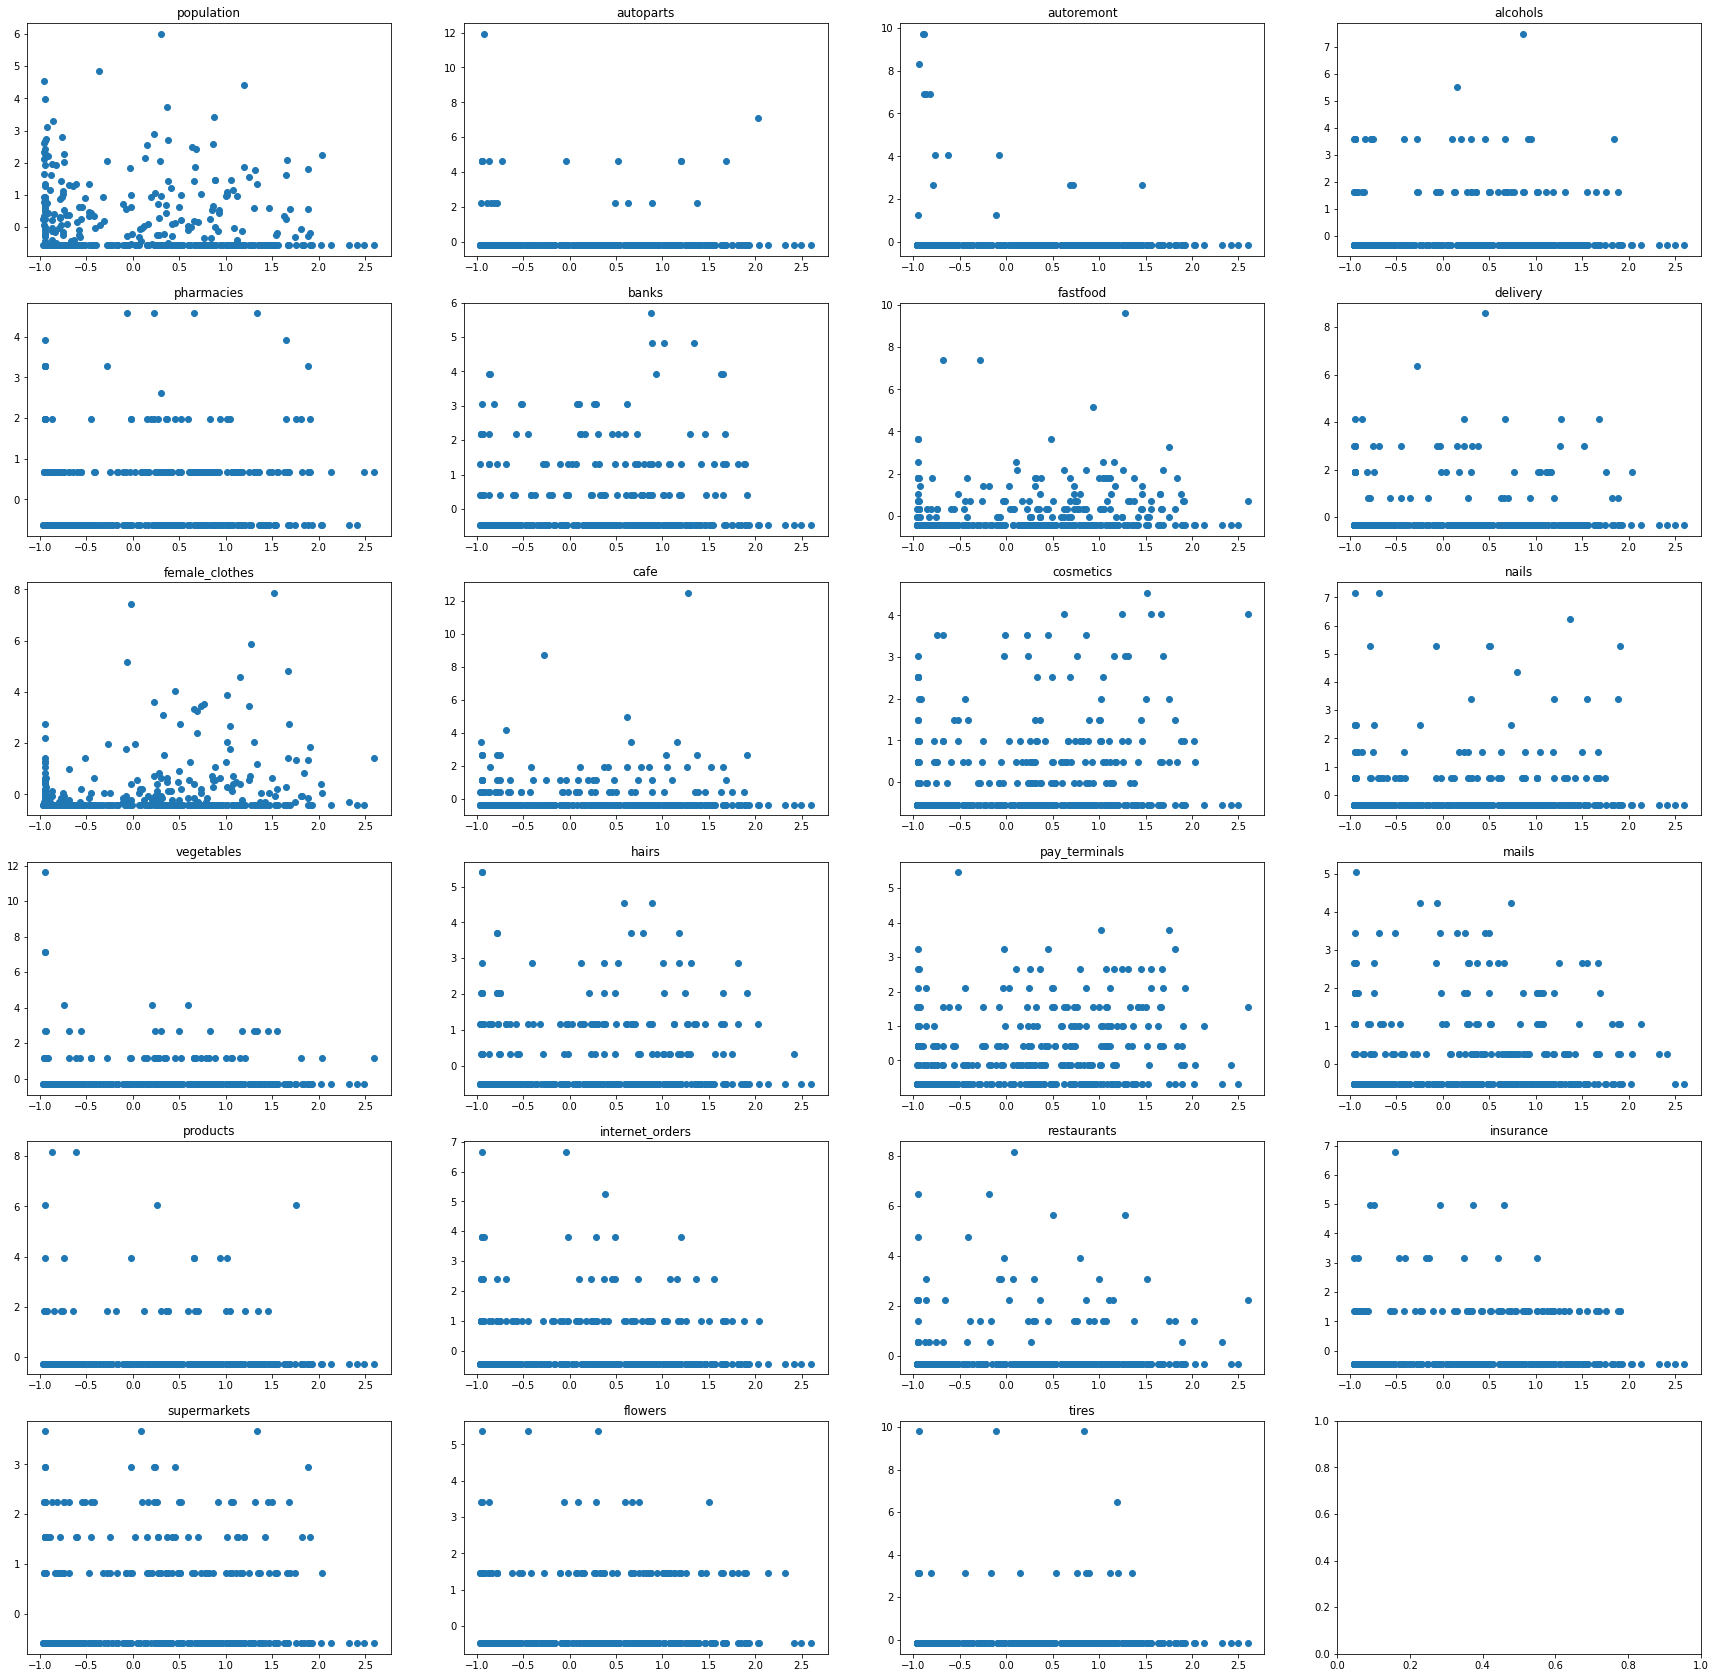

In [101]:
plt.rcParams["figure.figsize"] = (30,30)
fig, axs = plt.subplots(nrows=len(num_features) // 4 + min(1, len(num_features)%4), ncols=4)
for id, feature in enumerate(num_features):
    axs[id // 4, id % 4].scatter(df['target'], df[feature])
    axs[id // 4, id % 4].set_title(feature)
plt.show()

In [190]:
X_train, X_test, y_train, y_test = train_test_split(df[features], (df[target] - df[target].min()) / (df[target].max() - df[target].min()), test_size=0.3, random_state=228)
train_data = lgb.Dataset(X_train, label=y_train, feature_name=features, categorical_feature=cat_features, free_raw_data = False)
test_data = lgb.Dataset(X_test, label=y_test, feature_name=features, categorical_feature=cat_features, free_raw_data = False)

In [191]:
train_data = lgb.Dataset(df[features], label=df[target], feature_name=features, categorical_feature=cat_features, free_raw_data = False)

In [192]:
param = {
    'objective': 'regression_l1',
    'lambda_l1': 0.01,
#     'boosting': 'goss',
    'max_depth': 2,
    'subsample': 1.0,
    'num_iterations': 30,
    'learning_rate': 1e-1,
    'num_leaves': 4,
    'device_type': 'cpu',
    'seed': 228,
    'verbosity': 1,
    'metric': 'l1',
    'feature_fraction': 0.63,
#     'bagging_freq': 3
}
# booster = lgb.train(param, train_data, valid_sets=[test_data], categorical_feature=cat_features)
res = lgb.cv(param, train_data, nfold=5, return_cvbooster=True, stratified=False)
booster = res['cvbooster'].boosters[0]
res

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000230 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 240
[LightGBM] [Info] Number of data points in the train set: 392, number of used features: 21
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000232 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 240
[LightGBM] [Info] Number of data points in the train set: 392, number of used features: 21
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 240
[LightGBM] [Info] Number of data points in the train set: 392, number of used features: 21
[Ligh

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


{'l1-mean': [0.7749416528592762,
  0.7605925843676133,
  0.7457264954902422,
  0.732832027718194,
  0.7226298439714035,
  0.7137534692244563,
  0.7060687244126692,
  0.6987405751029598,
  0.6934374423180538,
  0.6890468715877327,
  0.6858866441142397,
  0.6821566430438788,
  0.678771938391829,
  0.6750693396647673,
  0.6724806498428236,
  0.6713262023778752,
  0.669782619589914,
  0.6675447728955504,
  0.6657573829754642,
  0.6645034854739537,
  0.6643015294907336,
  0.662402677767593,
  0.6619324329716949,
  0.6619375920875253,
  0.6609629216634348,
  0.6610499113453183,
  0.6608273605459966,
  0.6602110485196897,
  0.6591464079940584,
  0.6596006266541111],
 'l1-stdv': [0.04433491939091518,
  0.046338154469644045,
  0.04763992617733644,
  0.048670214821751004,
  0.050962886478488685,
  0.052664598831187466,
  0.05576367033852512,
  0.05852511082116029,
  0.0591112155982137,
  0.059044654244007864,
  0.059982450129869316,
  0.06024892535453263,
  0.06017266441492719,
  0.0608124956429

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

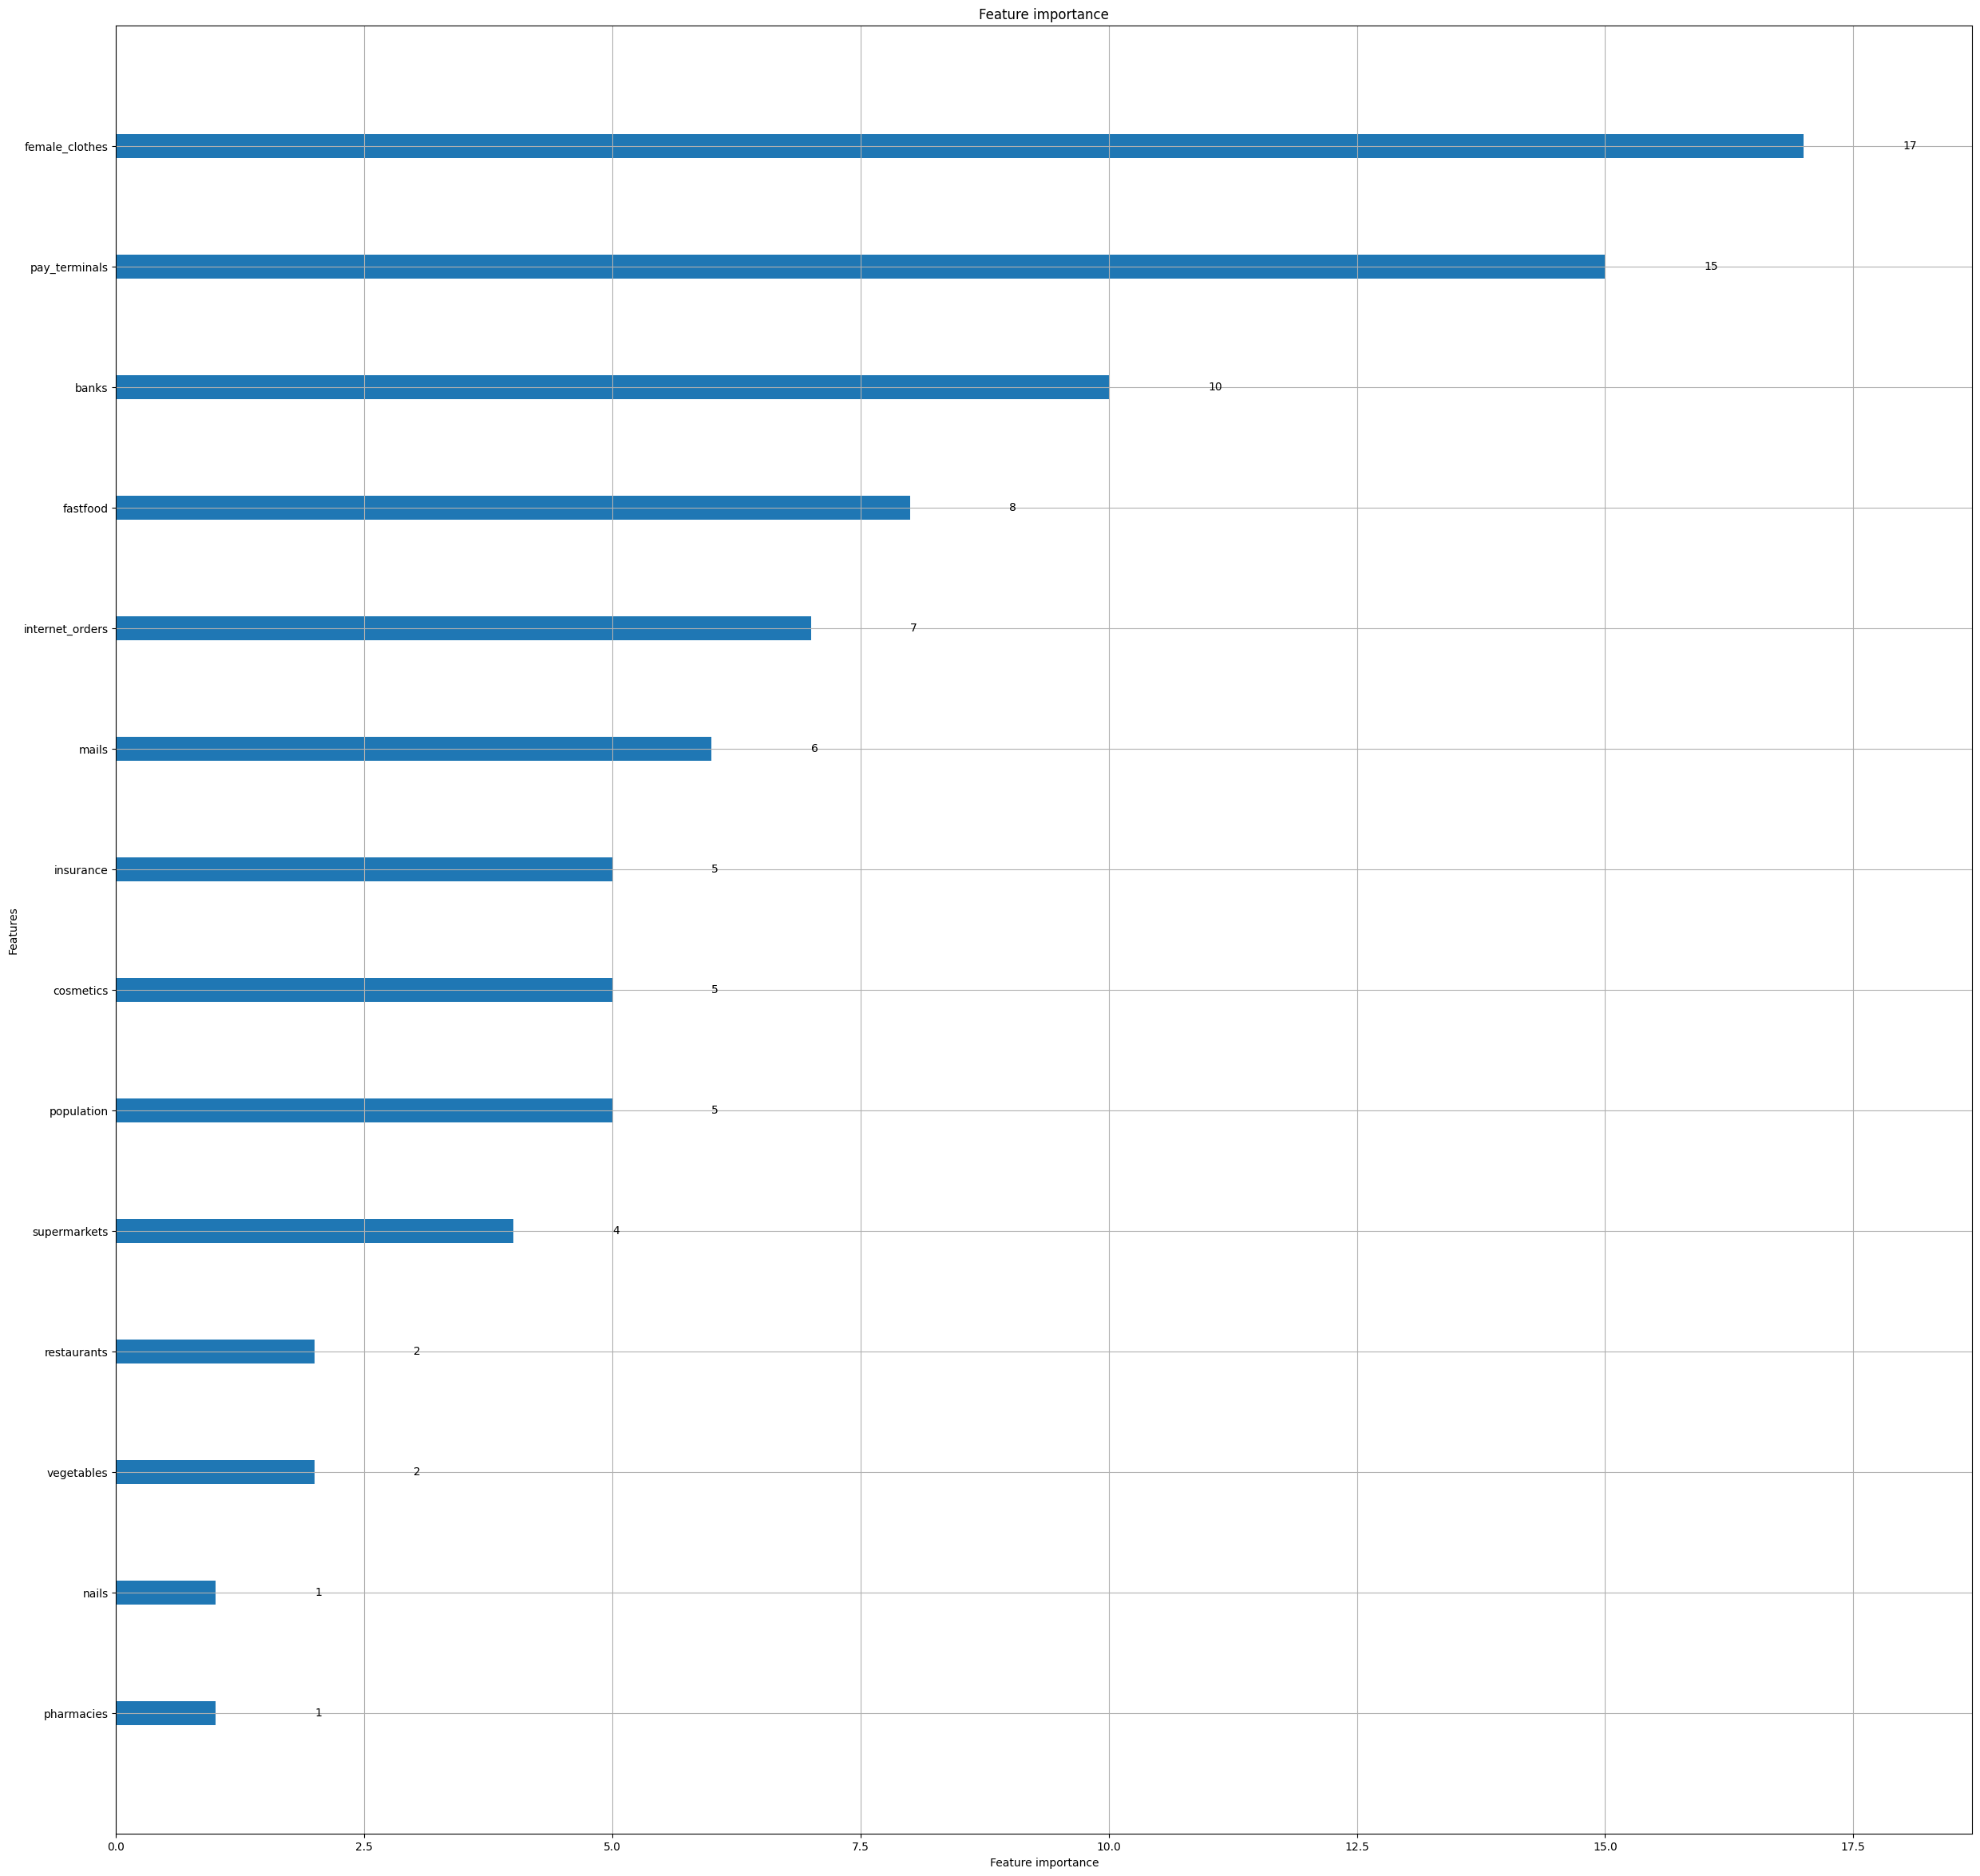

In [129]:
lgb.plot_importance(booster, importance_type='split', dpi=100, max_num_features=20)

In [189]:
ohe_cols = [col for col in df.columns if col.startswith(tuple([item + '_' for item in cat_features]))]
X = df[num_features + ohe_cols].values
y = df[target].values
y = (y - y.min()) / (y.max() - y.min())
X_train, X_test, y_train, y_test = train_test_split(df[num_features + ohe_cols], df[target], test_size=0.3, random_state=332)
lr = linear_model.Lasso(alpha=0.01, max_iter=100).fit(X_train, y_train)
k_fold = KFold(5, shuffle=True)
scores = []
lr = linear_model.LassoCV(max_iter=1000)
for k, (train, test) in enumerate(k_fold.split(X, y)):
    lr.fit(X[train], y[train])
    scores.append(mean_absolute_error(y[test], lr.predict(X[test])))
print(float(np.mean(scores)))
# mean_absolute_error(y_test, lr.predict(X_test))
scores

0.21021299784280084


[0.20018527702702976,
 0.21031818529721935,
 0.20618873773285407,
 0.20827909176635465,
 0.22609369739054652]

In [196]:
import tensorflow as tf
ohe_cols = [col for col in df.columns if col.startswith(tuple([item + '_' for item in cat_features]))]
X = df[num_features + ohe_cols].values
y = df[target].values
y = (y - y.min()) / (y.max() - y.min())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=332)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(
        128,
        activation=None,
        use_bias=True,
        kernel_initializer='glorot_uniform',
        kernel_regularizer=tf.keras.regularizers.L1(1e-4),
        bias_regularizer=tf.keras.regularizers.L1(1e-4)
    ),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Dense(
        64,
        activation=None,
        use_bias=True,
        kernel_initializer='glorot_uniform',
        kernel_regularizer=tf.keras.regularizers.L1(1e-4),
        bias_regularizer=tf.keras.regularizers.L1(1e-4)
    ),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation(tf.keras.activations.sigmoid)
])
model.compile(optimizer=tf.keras.optimizers.Adam(0.1), loss=tf.keras.losses.MeanSquaredError(), metrics=tf.keras.metrics.MeanAbsoluteError())
model.fit(x=X_train, y=y_train, epochs=15, workers=4, validation_data=(X_test, y_test), use_multiprocessing=True, shuffle=True)
model.evaluate(X_train, y_train)

Epoch 1/15
11/11 [==============================] - 1s 30ms/step - loss: 0.2130 - mean_absolute_error: 0.2547 - val_loss: 0.1572 - val_mean_absolute_error: 0.2111
Epoch 2/15
11/11 [==============================] - 0s 8ms/step - loss: 0.1427 - mean_absolute_error: 0.2224 - val_loss: 0.1143 - val_mean_absolute_error: 0.2001
Epoch 3/15
11/11 [==============================] - 0s 8ms/step - loss: 0.1162 - mean_absolute_error: 0.2090 - val_loss: 0.1109 - val_mean_absolute_error: 0.1934
Epoch 4/15
11/11 [==============================] - 0s 7ms/step - loss: 0.1111 - mean_absolute_error: 0.2078 - val_loss: 0.1052 - val_mean_absolute_error: 0.1886
Epoch 5/15
11/11 [==============================] - 0s 7ms/step - loss: 0.1013 - mean_absolute_error: 0.2071 - val_loss: 0.1004 - val_mean_absolute_error: 0.1961
Epoch 6/15
11/11 [==============================] - 0s 7ms/step - loss: 0.1001 - mean_absolute_error: 0.2107 - val_loss: 0.0943 - val_mean_absolute_error: 0.1956
Epoch 7/15
11/11 [=========

[0.08905629813671112, 0.18733923137187958]

In [131]:
pd.DataFrame(list(zip(lr.coef_, num_features + ohe_cols)), columns=['importance', 'feature']).sort_values(by='importance')

,importance,feature
17,-0.087878,internet_orders
2,-0.067059,autoremont
16,-0.059035,products
15,-0.058609,mails
20,-0.057881,supermarkets
7,-0.029357,delivery
0,-0.012837,population
18,-0.006153,restaurants
12,-0.003822,vegetables
3,0.000000,alcohols


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='target', ylabel='Density'>

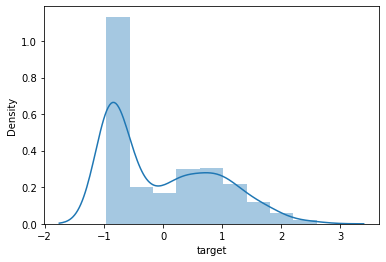

In [31]:
sns.distplot(df['target'], kde=True)

In [32]:
def get_radius(row):
    lat = float(row['lat'])
    lon = float(row['lon'])
    poly_str = row['walk_15min'].replace('POLYGON ((', '').replace('))', '')
    points = poly_str.split(',')
    dist = 0
    for point_str in points:
        items = point_str.strip().split(' ')
        _lon = float(items[0])
        _lat = float(items[1])
        dist += np.sqrt((lat - _lat) ** 2 + (lon - _lon) ** 2)
    return float(dist) / len(points)
    
df_isochrones['radius'] = df_isochrones.apply(get_radius, axis=1) / 3 # 5 mins
mean_radius = df_isochrones['radius'].mean()
print(mean_radius)
df_isochrones['radius'].describe()

0.00373524827601356


count    47097.000000
mean         0.003735
std          0.000580
min          0.000357
25%          0.003375
50%          0.003795
75%          0.004151
max          0.020630
Name: radius, dtype: float64

In [33]:
filled_hexs = set(df[geo_id].drop_duplicates().tolist())
tree = KDTree(df_isochrones[df_isochrones[geo_id].apply(lambda id: id in filled_hexs)][['lon', 'lat']].values)
dist, ind = tree.query(df_isochrones[['lon', 'lat']].values, k=1)
uncovered = set(df_isochrones[dist > mean_radius][geo_id].drop_duplicates().tolist())
covered = set(df_isochrones[dist < mean_radius][geo_id].drop_duplicates().tolist())
total_peoples = df_population[df_population[geo_id].apply(lambda id: id in covered)]['population'].sum()
print(total_peoples)

1654839


In [34]:
def population_metric(hexs, top_n=20):
    
    best_hexs = set([hex_id for hex_id in hexs if hex_id in uncovered][:top_n])
    small_tree = KDTree(df_isochrones[df_isochrones[geo_id].apply(lambda id: id in best_hexs)][['lon', 'lat']].values)
    df_uncovered = df_population[df_population[geo_id].apply(lambda id: id in uncovered)]
    
    dist, ind = small_tree.query(df_uncovered[['lon', 'lat']].values, k=1)
    new_peoples = df_uncovered[dist < mean_radius]['population'].sum()
    uplift = (new_peoples) / (total_peoples) * 100
    
    return uplift

def combined_metric(hexs, top_n=20):
    
    targets = set(target_df[geo_id].drop_duplicates().tolist())
    bounded_hexs = hexs[:len(targets) + top_n]
    recall = sum([1 if hex in targets else 0 for hex in bounded_hexs]) / min(len(targets), len(bounded_hexs))
    
    return recall

In [35]:
print(population_metric(df_population.sort_values(by='population', ascending=False)[geo_id].drop_duplicates().tolist(), 30))
print(combined_metric(df_population.sort_values(by='population', ascending=False)[geo_id].drop_duplicates().tolist(), 30))

14.464428261601281
0.010141987829614604


In [36]:
_df = df_population.drop_duplicates(subset=geo_id)
_df = _df.merge(df_companies, on=geo_id, suffixes=(None, '_y'), how='left').drop(['city_y', 'lat_y', 'lon_y'], axis=1).fillna(0)
_df = _df.rename(columns=column_mapper)

for feature in num_features:
    _df[feature] = (_df[feature] - _df[feature].mean())/ _df[feature].std()
_df

for feature in cat_features:
    _df[f'{feature}_ohe'] = _df[feature]
_df = pd.get_dummies(_df, columns=[f'{col}_ohe' for col in cat_features], prefix=cat_features)

In [37]:
# _df['prediction'] = booster.predict(_df[features])
_df['prediction'] = lr.predict(_df[features])
print(population_metric(_df.sort_values(by='prediction', ascending=False)[geo_id].drop_duplicates().tolist(), 30))
print(combined_metric(_df.sort_values(by='prediction', ascending=False)[geo_id].drop_duplicates().tolist(), 30))

10.157664884620196
0.1257606490872211


In [38]:
df_uncovered = df_population[df_population[geo_id].apply(lambda id: id in uncovered)]
uncovered_pops = df_uncovered['population'].tolist()
uncovered_hexs = df_uncovered[geo_id].tolist()
uncovered_tree = KDTree(df_uncovered[['lon', 'lat']].values)
indices = uncovered_tree.query_radius(df_uncovered[['lon', 'lat']].values, r=mean_radius)
terminals = 30

tmp_covered = set()
selected = []
total_lift = 0
for current_terminal in range(terminals):
    best_lift = 0
    best_item = 0
    for item_id, items in enumerate(indices):
        added = sum([uncovered_pops[item] for item in set(items) if item not in tmp_covered])
        lift = added / total_peoples * 100
        if lift > best_lift:
            best_lift = lift
            best_item = item_id
            
    total_lift += best_lift
    selected.append(uncovered_hexs[best_item])
    tmp_covered.update(set(indices[best_item]))
    
print(f'Total lift: {total_lift}')
print('Hexagon indices: ', selected)
print(combined_metric(selected, len(selected)))

Total lift: 27.072482579876354
Hexagon indices:  ['8a1106aa66dffff', '8a1106150117fff', '8a1106ab1867fff', '8a1106ab464ffff', '8a11061543affff', '8a1106ab3327fff', '8a110606ca47fff', '8a0bb032a217fff', '8a0bb035118ffff', '8a1106ab40effff', '8a110614c16ffff', '8a1106a86047fff', '8a1106043ca7fff', '8a1106aa25a7fff', '8a1106150837fff', '8a0bb0370c77fff', '8a1106042b6ffff', '8a110616924ffff', '8a110600c977fff', '8a1106a93737fff', '8a0bb034206ffff', '8a1106a80acffff', '8a1106ab32affff', '8a1106a98b17fff', '8a0bb0340da7fff', '8a1106ab579ffff', '8a1106a80657fff', '8a1106141307fff', '8a110614c21ffff', '8a1106ab021ffff']
0.0


In [202]:
import pandas as pd
import numpy as np

from sklearn.neighbors import KDTree

def drop_dups(df):
    return df.drop_duplicates(subset=[geo_id])

ROOT = '/kaggle/input/geo-branch-data/train/train'
geo_id = 'geo_h3_10'
df_population = drop_dups(pd.read_csv(f"{ROOT}/rosstat_population_all_cities.csv"))
df_isochrones = drop_dups(pd.read_csv(f"{ROOT}/isochrones_walk_dataset.csv"))
df_companies = drop_dups(pd.read_csv(f"{ROOT}/osm_amenity.csv"))
df_target = drop_dups(pd.read_csv('/kaggle/input/bankmachinesrussia/target_hakaton_spb.csv', sep=';', encoding='Windows-1251'))

geo_id_mapper = dict(df_isochrones.apply(lambda row: (row[geo_id], (row['lat'], row['lon'])), axis=1).tolist())

    
def prepare_df(df):
    _df = df.merge(df_population, on=geo_id, suffixes=(None, '_y'), how='left').drop(['lat', 'lon', 'city'], axis=1)
    _df = _df.merge(df_companies, on=geo_id, suffixes=(None, '_y'), how='left').drop(['city', 'lat', 'lon'], axis=1).fillna(0)

    _df = _df.rename(columns=column_mapper)
    for feature in num_features:
        _df[feature] = (_df[feature] - _df[feature].mean())/ _df[feature].std()

    for feature in cat_features:
        _df[f'{feature}_ohe'] = _df[feature]
    _df = pd.get_dummies(_df, columns=[f'{col}_ohe' for col in cat_features], prefix=cat_features)

    return _df

def prepare_df2(df):
    _df = df.merge(df_companies, on=geo_id, suffixes=(None, '_y'), how='left').drop(['city', 'lat', 'lon'], axis=1).fillna(0)

    _df = _df.rename(columns=column_mapper)
    for feature in num_features:
        _df[feature] = (_df[feature] - _df[feature].mean())/ _df[feature].std()

    for feature in cat_features:
        _df[f'{feature}_ohe'] = _df[feature]
    _df = pd.get_dummies(_df, columns=[f'{col}_ohe' for col in cat_features], prefix=cat_features)

    ohe_cols = [col for col in _df.columns if col.startswith(tuple([item + '_' for item in cat_features]))]
    X = _df[num_features + ohe_cols].values
    
    return X

def prepare_target(_df):
    _df[target] = _df[target] / _df['atm_cnt']
    _df[target] = (_df[target] - _df[target].mean())/ _df[target].std()

    _df = _df[_df[target] - _df[target].mean() < 3 * _df[target].std()]
    return _df

def get_regression(df_target):

    df_target = prepare_df(df_target)
    df_target = prepare_target(df_target)

    ohe_cols = [col for col in df_target.columns if col.startswith(tuple([item + '_' for item in cat_features]))]
    X = df_target[num_features + ohe_cols].values
    y = df_target[target].values
    y = (y - y.min()) / (y.max() - y.min())
    
    k_fold = KFold(5)
    scores = []
    lr = linear_model.LassoCV(max_iter=1000)
    for k, (train, test) in enumerate(k_fold.split(X, y)):
        lr.fit(X[train], y[train])
        scores.append(mean_absolute_error(y[test], lr.predict(X[test])))
    print(f'Mean linear regression MAE: {float(np.mean(scores))}')
    
    return lr
lr = get_regression(df_target)
# df_isochrones = df_isochrones.merge(df_population, on=geo_id, how='left', suffixes=[None, '_y']).drop(['lat_y', 'lon_y', 'city_y'], axis=1)
# pop_values = df_population['population'].tolist()

# pop_tree = KDTree(df_population[['lon', 'lat']].values)
# def replace_na(row, tree):
#     if not math.isnan(row['population']):
#         return row
#     lon = float(row['lon'])
#     lat = float(row['lat'])
#     dist, ind = tree.query([[lon, lat]], k=3)
#     row['population'] = float(np.mean([pop_values[i] for i in ind[0]]))
#     return row
    
# df_isochrones = df_isochrones.apply(lambda row: replace_na(row, pop_tree), axis=1)

def get_mean_radius(df_isochrones):
    def get_radius(row):
        lat = float(row['lat'])
        lon = float(row['lon'])
        poly_str = row['walk_15min'].replace('POLYGON ((', '').replace('))', '')
        points = poly_str.split(',')
        dist = 0
        for point_str in points:
            items = point_str.strip().split(' ')
            _lon = float(items[0])
            _lat = float(items[1])
            dist += np.sqrt((lat - _lat) ** 2 + (lon - _lon) ** 2)
        return float(dist) / len(points)

    mean_radius = (df_isochrones.apply(get_radius, axis=1)).mean() # 5 mins
    
    return mean_radius

mean_radius = get_mean_radius(df_isochrones)
print(f'Mean isochrone radius: {mean_radius}')

cities = df_isochrones['city'].drop_duplicates().tolist()
print('Available cities: ', cities)

filled_hexs = set(df_target[geo_id].drop_duplicates().tolist())
filled_trees = {}
uncovered = {}
covered = {}
total_peoples = {}
uncovered_df = {}
uncovered_trees = {} 

for city in cities:
    city_isochrones = df_isochrones[df_isochrones['city'].apply(lambda val: val == city)]
    filled_trees[city] = KDTree(city_isochrones[city_isochrones[geo_id].apply(lambda id: id in filled_hexs)][['lon', 'lat']].values)
    dist, ind = filled_trees[city].query(city_isochrones[['lon', 'lat']].values, k=1)
    uncovered[city] = set(city_isochrones[dist > mean_radius][geo_id].drop_duplicates().tolist())
    covered[city] = set(city_isochrones[dist < mean_radius][geo_id].drop_duplicates().tolist())
    peoples = df_population[df_population['city'].apply(lambda val: val == city)]['population'].sum()
    total_peoples[city] = df_population[df_population['city'].apply(lambda val: val == city) & df_population[geo_id].apply(lambda id: id in covered[city])]['population'].sum()
    print(f'City - {city}, peoples  - {peoples}, peoples covered - {total_peoples[city]}')
    
    df = df_population[df_population['city'].apply(lambda val: val == city) & df_population[geo_id].apply(lambda id: id in uncovered[city])]
    df['score'] = lr.predict(prepare_df2(df))
    uncovered_df[city] = df
    uncovered_trees[city] = KDTree(uncovered_df[city][['lon', 'lat']].values)
    

def get_predictions(city, uncovered_df, total_peoples, uncovered_trees, mean_radius, geo_id='geo_h3_10', n=20):
    uncovered_pops = uncovered_df[city]['population'].tolist()
    uncovered_hexs = uncovered_df[city][geo_id].tolist()
    uncovered_scores = uncovered_df[city]['score'].tolist()

    indices = uncovered_trees[city].query_radius(uncovered_df[city][['lon', 'lat']].values, r=mean_radius)

    tmp_covered = set()
    selected = []
    total_lift = 0
    lifts = []
    for current_terminal in range(n):
        best_lift = 0
        best_item = 0
        for item_id, items in enumerate(indices):
            added = sum([uncovered_pops[item] for item in set(items) if item not in tmp_covered])
            lift = added / total_peoples[city] * 100
            score = uncovered_scores[item_id]
            if lift * score > best_lift:
                best_lift = lift * score
                best_item = item_id

        total_lift += best_lift
        lifts.append(total_lift)
        selected.append(uncovered_hexs[best_item])
        tmp_covered.update(set(indices[best_item]))

    return lifts, selected

total_lift, selected = get_predictions(cities[1], uncovered_df, total_peoples, uncovered_trees, mean_radius, geo_id, 5)
coords = [geo_id_mapper[id] for id in selected]
print(f'Total lift: {total_lift[-1]}')
print('Hexagon indices: ', selected)
print(coords)

Mean linear regression MAE: 0.21094262559092108
Mean isochrone radius: 0.01120574482804068
Available cities:  ['Нижний Новгород', 'Санкт-Петербург', 'Новосибирск', 'Екатеринбург']
City - Нижний Новгород, peoples  - 1465501, peoples covered - 790613


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


City - Санкт-Петербург, peoples  - 5158815, peoples covered - 3474677
City - Новосибирск, peoples  - 2002930, peoples covered - 1210902


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


City - Екатеринбург, peoples  - 1787172, peoples covered - 1238853


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Total lift: 5.0007926351583585
Hexagon indices:  ['8a11061508a7fff', '8a1106a9ac67fff', '8a110605480ffff', '8a110610946ffff', '8a1106068b87fff']
[(59.85925148411486, 30.184861339936905), (60.00831604150972, 30.41764629655064), (59.86675886048348, 30.412387370604115), (59.83556351914888, 30.145615650118348), (59.97913138259936, 30.42160238629182)]


30
Екатеринбург


<AxesSubplot:>

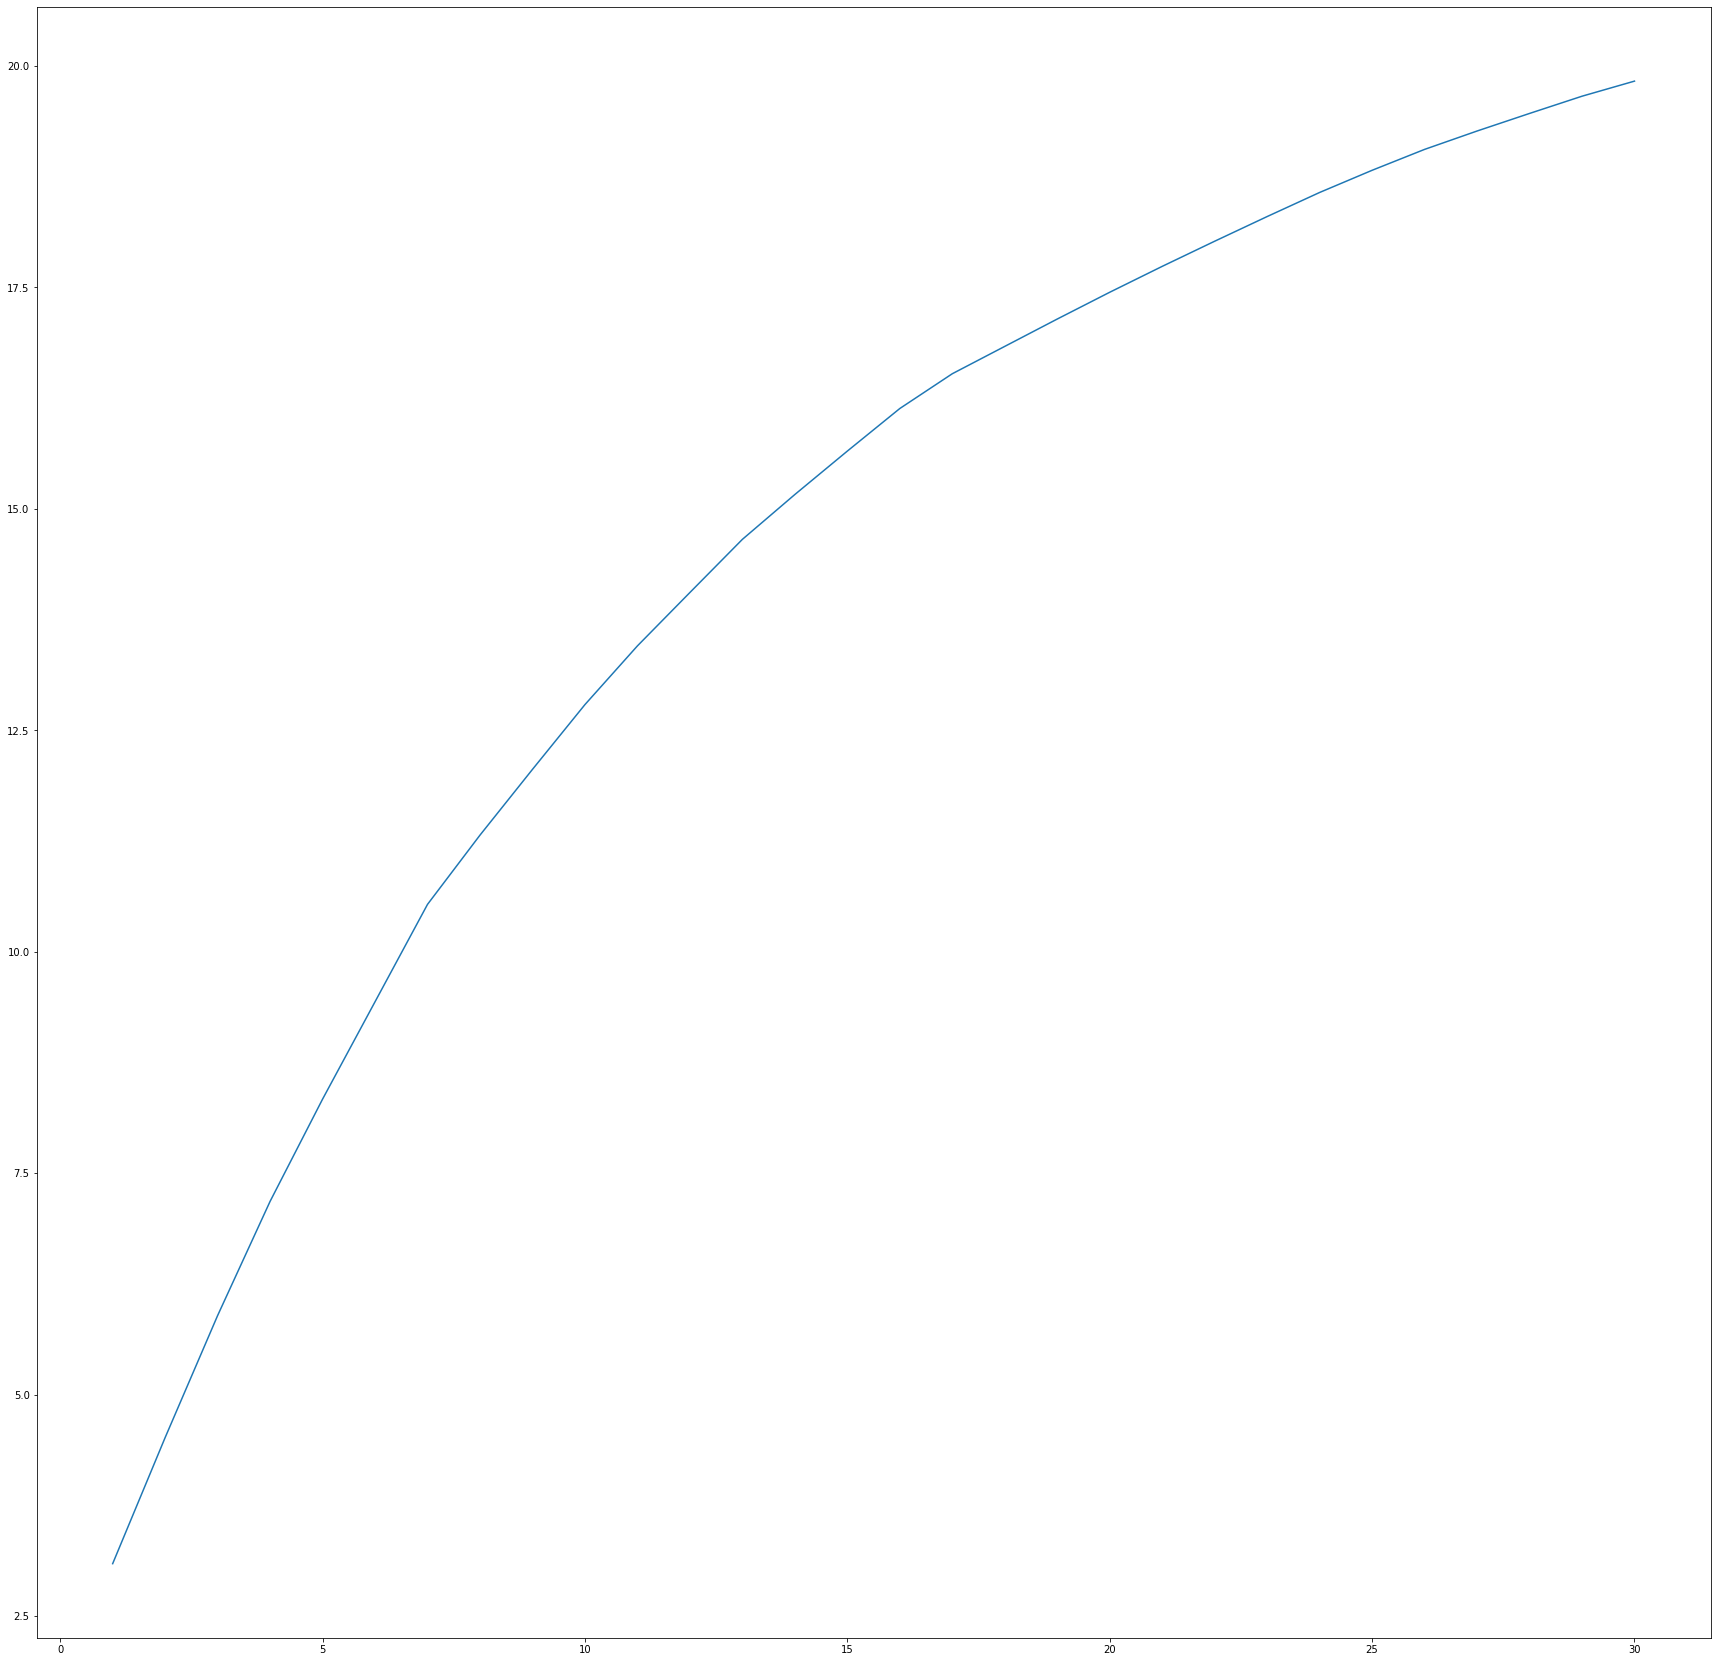

In [206]:
import seaborn as sns
city_id = 3
lifts, selected = get_predictions(cities[city_id], uncovered_df, total_peoples, uncovered_trees, mean_radius, geo_id, 30)
print(len(lifts))
print(cities[city_id])
sns.lineplot(x=np.arange(1, 31), y=lifts)

In [79]:
lifts[0]

2.3802788000150805

In [81]:
hexs = selected
hexs_set = set(selected)
df_companies[df_companies[geo_id].apply(lambda id: id in hexs_set)]

,gorod,geo_h3_10,lat_h3,lon_h3,atm_category,target,atm_cnt
0,Екатеринбург,8a10c2283357fff,56.865861,60.532224,category4,95.333333,1
1,Екатеринбург,8a10c2288087fff,56.885391,60.588203,category3,30652.666667,4
2,Екатеринбург,8a10c228820ffff,56.891648,60.605399,category2,1162.166667,1
3,Екатеринбург,8a10c2288adffff,56.895039,60.598777,category1,2961.333333,1
4,Екатеринбург,8a10c228944ffff,56.896206,60.625911,category1,2963.333333,1
...,...,...,...,...,...,...,...
532,Санкт-Петербург,8a1106ab618ffff,59.986278,30.217541,category1,10523.666667,1
533,Санкт-Петербург,8a1106ab67a7fff,59.983488,30.227538,category1,2535.833333,1
534,Санкт-Петербург,8a1106ab6807fff,59.990519,30.205250,category1,23519.500000,2
536,Санкт-Петербург,8a1106ab6ae7fff,59.996443,30.219656,category2,489.500000,1
